# Impact of bit collisions on learning performance

**Note**: This is a significantly revised version of an [earlier post](https://rdkit.blogspot.com/2014/03/colliding-bits-ii.html).

In an [earlier post](http://rdkit.blogspot.ch/2014/02/colliding-bits.html) I looked at the minimal impact bit collisions in the RDKit's Morgan fingerprints has on calculated similarity between molecules. This time I'm going to look at the impact of fingerprint size (as a surrogate for number of collisions) on the performance of machine-learning algorithms.

I will use Datasets II from our [model fusion](https://pubs.acs.org/doi/abs/10.1021/ci400466r) paper to do the analysis. I've looked at these datasets, which are available as part of the [benchmarkng platform](https://github.com/rdkit/benchmarking_platform) in some detail in an [earlier post](https://rdkit.blogspot.ch/2014/02/more-on-datasets-ii.html).

While working on this post I updated the benchmarking platform to work with Python 3 (the paper was a long time ago!) and added a few additional learning methods and one additional evaluation metric. Those will be merged back to the github repo soon (probably by the time this blog post actually appears), in the meantime it's [here](https://github.com/greglandrum/benchmarking_platform/tree/update_to_modern_py) (if that branch is missing, it indicates that the code is already merged to the main repo).

The fingerprints examined here:
1. MFP2: Morgan fingerprint, radius = 2
2. MFP3: Morgan fingerprint, radius = 3
3. RDK5: RDKit fingerprint, max path length = 5
4. HashAP: atom pairs, using [count simulation](https://www.rdkit.org/docs/RDKit_Book.html#atom-pair-and-topological-torsion-fingerprints)
5. HashTT: topological torsions, [using count simulation](https://www.rdkit.org/docs/RDKit_Book.html#atom-pair-and-topological-torsion-fingerprints)

The benchmarking platform is pre-configured to support a short (1K) and long (16K) form of the fingerprints, so that part was easy.

The learning algorithms:
1. LR: logistic regression, sklearn implementation
2. LMNB: Laplacian Naive Bayes, [NIBR implementation](https://github.com/rdkit/lmnb)
3. NB: Naive Bayes, sklearn implementation. Note that something went wrong with these calculations, so they won't be included in any summaries.
4. RF: random forest, sklearn implementation
5. BRF: balanced random forest, [imbalanced-learn implementation](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html)
6. XGB: extreme gradient boosting, [XGBoost implementation](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)

Here's a summary of the results using AUC as a metric (there's a giant table at the bottom with the other metrics).
The `result` column indicates whether the AUC value for the short fingerprint is usually less than (`lt`), the same as `same`, or greater than (`gt`) the AUC value for the long fingerprint. The `P` column provides the P value for the difference (assessed using scipy's [Wilcoxon signed-rank test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html). The `delt` column has the median difference between the short-fingerprint AUC and long-fingerprint AUC. The `pct_delt` column indicates the median percentage change in AUC relative to the short-fingerprint AUC.

| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | AUC | lt | 8.68e-51 | -0.011 | -0.0142 |
| lr | mfp3 | AUC | lt | 2.6e-64 | -0.019 | -0.0243 |
| lr | rdk5 | AUC | lt | 2.09e-24 | -0.011 | -0.0143 |
| lr | hashap | AUC | lt | 8.77e-37 | -0.026 | -0.0325 |
| lr | hashtt | AUC | lt | 8.02e-54 | -0.022 | -0.0294 |
| lmnb | mfp2 | AUC | lt | 3.2e-104 | -0.042 | -0.0573 |
| lmnb | mfp3 | AUC | lt | 6.05e-107 | -0.077 | -0.109 |
| lmnb | rdk5 | AUC | lt | 4.32e-60 | -0.071 | -0.193 |
| lmnb | hashap | AUC | gt | 1.67e-18 | 0.031 | 0.0494 |
| lmnb | hashtt | AUC | lt | 7.52e-105 | -0.051 | -0.0767 |
| rf | mfp2 | AUC | lt | 1.45e-102 | -0.087 | -0.132 |
| rf | mfp3 | AUC | lt | 2.23e-92 | -0.074 | -0.115 |
| rf | rdk5 | AUC | gt | 4.27e-11 | 0.015 | 0.0212 |
| rf | hashap | AUC | same | 0.00227 | 0.0036 | 0.00503 |
| rf | hashtt | AUC | lt | 1.25e-63 | -0.046 | -0.0677 |
| brf | mfp2 | AUC | lt | 6.61e-37 | -0.024 | -0.0304 |
| brf | mfp3 | AUC | lt | 9.25e-40 | -0.031 | -0.04 |
| brf | rdk5 | AUC | gt | 2.77e-09 | 0.01 | 0.0131 |
| brf | hashap | AUC | gt | 5.32e-07 | 0.011 | 0.0152 |
| brf | hashtt | AUC | lt | 8.45e-29 | -0.027 | -0.0362 |
| xgb | mfp2 | AUC | same | 0.831 | 0.00097 | 0.00109 |
| xgb | mfp3 | AUC | same | 0.00162 | -0.0051 | -0.00719 |
| xgb | rdk5 | AUC | gt | 1.36e-07 | 0.012 | 0.0157 |
| xgb | hashap | AUC | gt | 1.49e-20 | 0.027 | 0.0358 |
| xgb | hashtt | AUC | same | 0.0265 | -0.0043 | -0.00645 |

The TL;DR from this: for most methods and fingerprints you can get a small, but real improvement in model performance (as measured by AUC) by using the longer fingerprints. There are a few cases, e.g. LMNB+rdk5 and RF+mfp2, where the model built with the longer fingerprint is >10% better. Exceptions to the general rule, which it could be interesting to investigate more deeply, include:
- The `rdk5` and `hashap` fingerprints: for this use case it looks like the additional information in the longer fingerprints tends to degrade performance. The "simpler" learning algorithms - `lr` and `lmnb` - either don't show this effect or show it less... a strong suggestion that the problem is overfitting.
- XGB doesn't show improved performance for the longer fingerprint with any of the methods.

Note that we've only looked at one type of data set here - training on reasonably homogeneous active molecules and then testing with diverse actives - so the results could well be different for models built/tested on things like screening data (where both the training and test sets are chemically diverse).



In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import numpy as np

import rdkit
print(rdkit.__version__)
import time
print(time.asctime())
%pylab inline

2022.09.1
Mon Dec 19 20:00:39 2022
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Datasets II results from the benchmarking platform

Read in the results from running the benchmarking platform:

In [2]:
from collections import defaultdict
import glob
import pickle
import gzip
alld = {}
for fn in glob.glob('../data/bp_results/dsII_validation/ChEMBL/*.pkl.gz'):
    with gzip.open(fn,'rb') as inf:
        d = pickle.load(inf)
    fn = fn.split('_')[-1].split('.')[0]
    alld[fn]=d


In [3]:
alld.keys()

dict_keys(['100', '10188', '10193', '10260', '10280', '10434', '107', '108', '10980', '11140', '11365', '114', '11489', '11534', '11575', '11631', '121', '12209', '12252', '126', '12952', '130', '13001', '15', '165', '17045', '19905', '25', '259', '43', '51', '61', '65', '72', '87', '90', '93'])

These are the evaluation metrics we'll use: AUC, EF1, EF5, and AUPRC (area onder the precision-recall curve). Note that you have to be careful comparing EF1, EF5, and AUPRC across data sets with different active/inactive ratios, but that doesn't affect us here since we only compare values within a given data set.

In [44]:
metrics = ('AUC','AUPRC','EF1','EF5',)

# Detailed view of the results for a particular method

Start by reproducing some of the plots we used last time, though we'll quickly switch to a view which is better suited to doing comparisons.

We'll just show the plots for logistic regression:

In [45]:
means=defaultdict(dict)
medians=defaultdict(dict)
delts=defaultdict(dict)
fdelts=defaultdict(dict)
for assay,d in alld.items():
    for metric in metrics:
        v1 = np.array([x[0] for x in d[metric]['lr_mfp2']])
        v2 = np.array([x[0] for x in d[metric]['lr_lmfp2']])
        delt=v2-v1
        means[assay][metric] = (np.mean(v1),np.mean(v2))
        medians[assay][metric] = (np.median(v1),np.median(v2))
        delts[assay][metric] = (np.mean(delt),np.min(delt),np.max(delt))
        fdelts[assay][metric] = delt
     
                  

Look at the mean values of the metrics across the different targets.

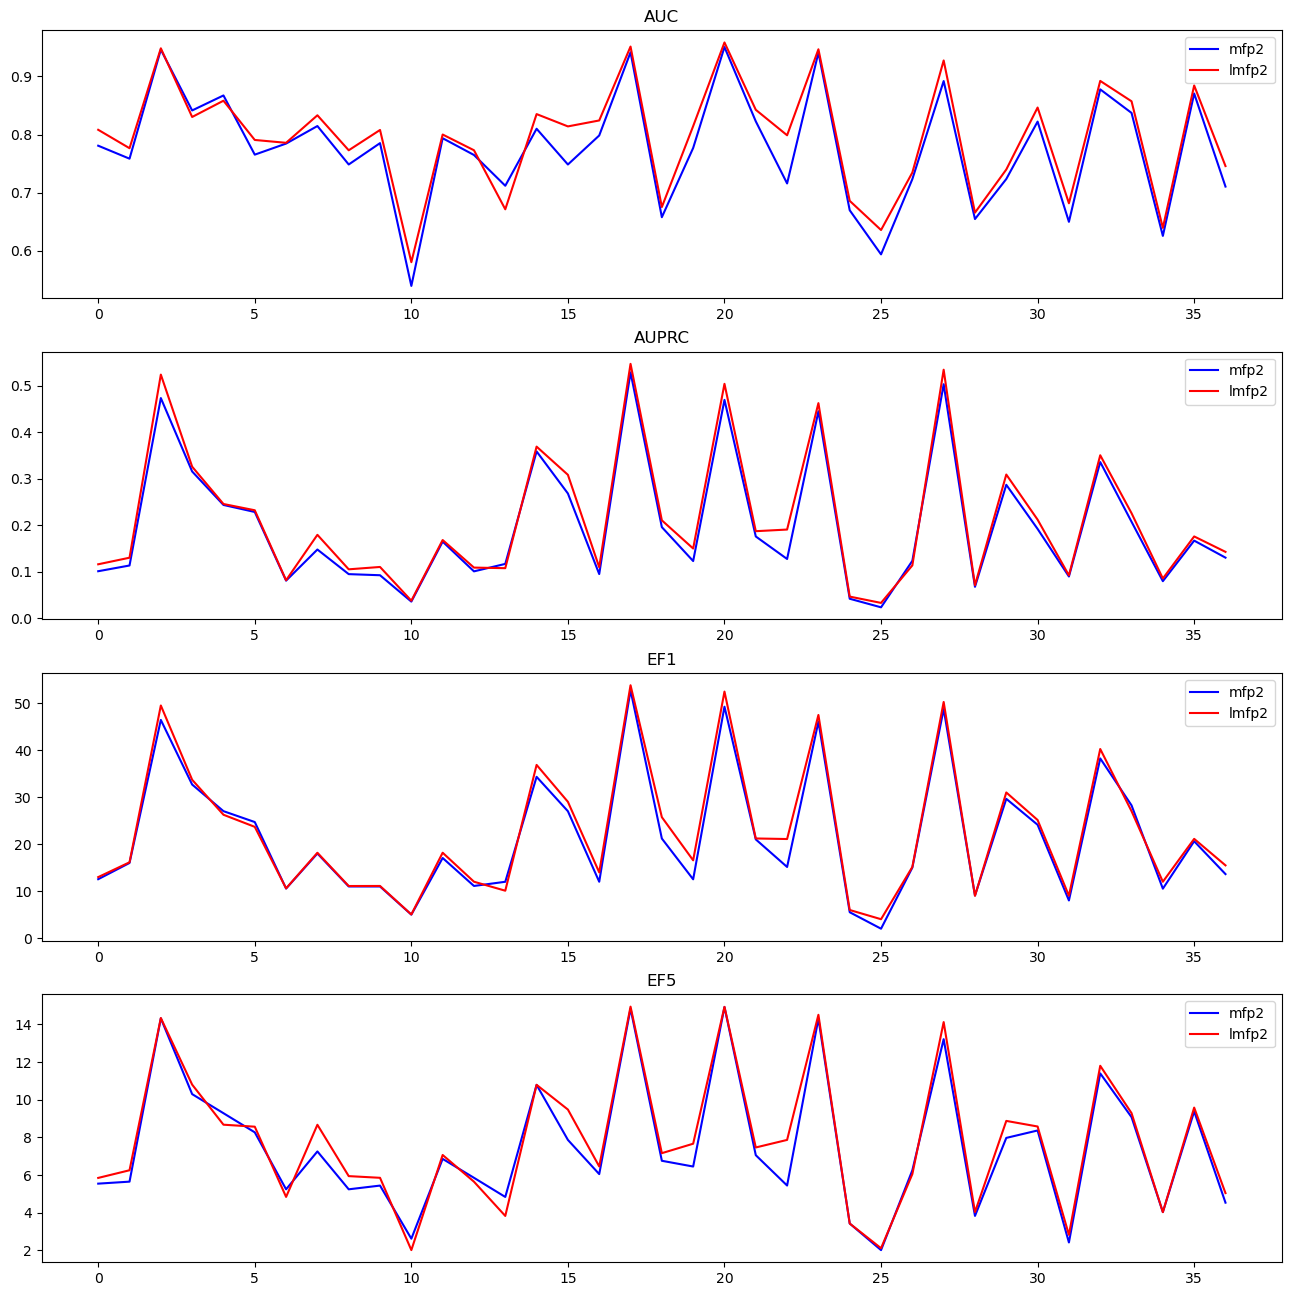

In [46]:
figsize(16,4*len(metrics))
for i,metric in enumerate(metrics):
    subplot(len(metrics),1,i+1)
    plot([x[metric][0] for x in medians.values()],c='b',label='mfp2')
    plot([x[metric][1] for x in medians.values()],c='r',label='lmfp2')
    title(metric)
    legend()

With LR, at least, the longer fingerprints (red lines) are, on average, slightly better with each metric.

Using the means here, which are calculated across multiple datasets (papers) per target isn't the most accurate way to view the results, it's more accurate to look at the deltas.

The same behavior is observed in the deltas, though the min delta curves do show that there are times that the longer fingerprints are sligthly worse:

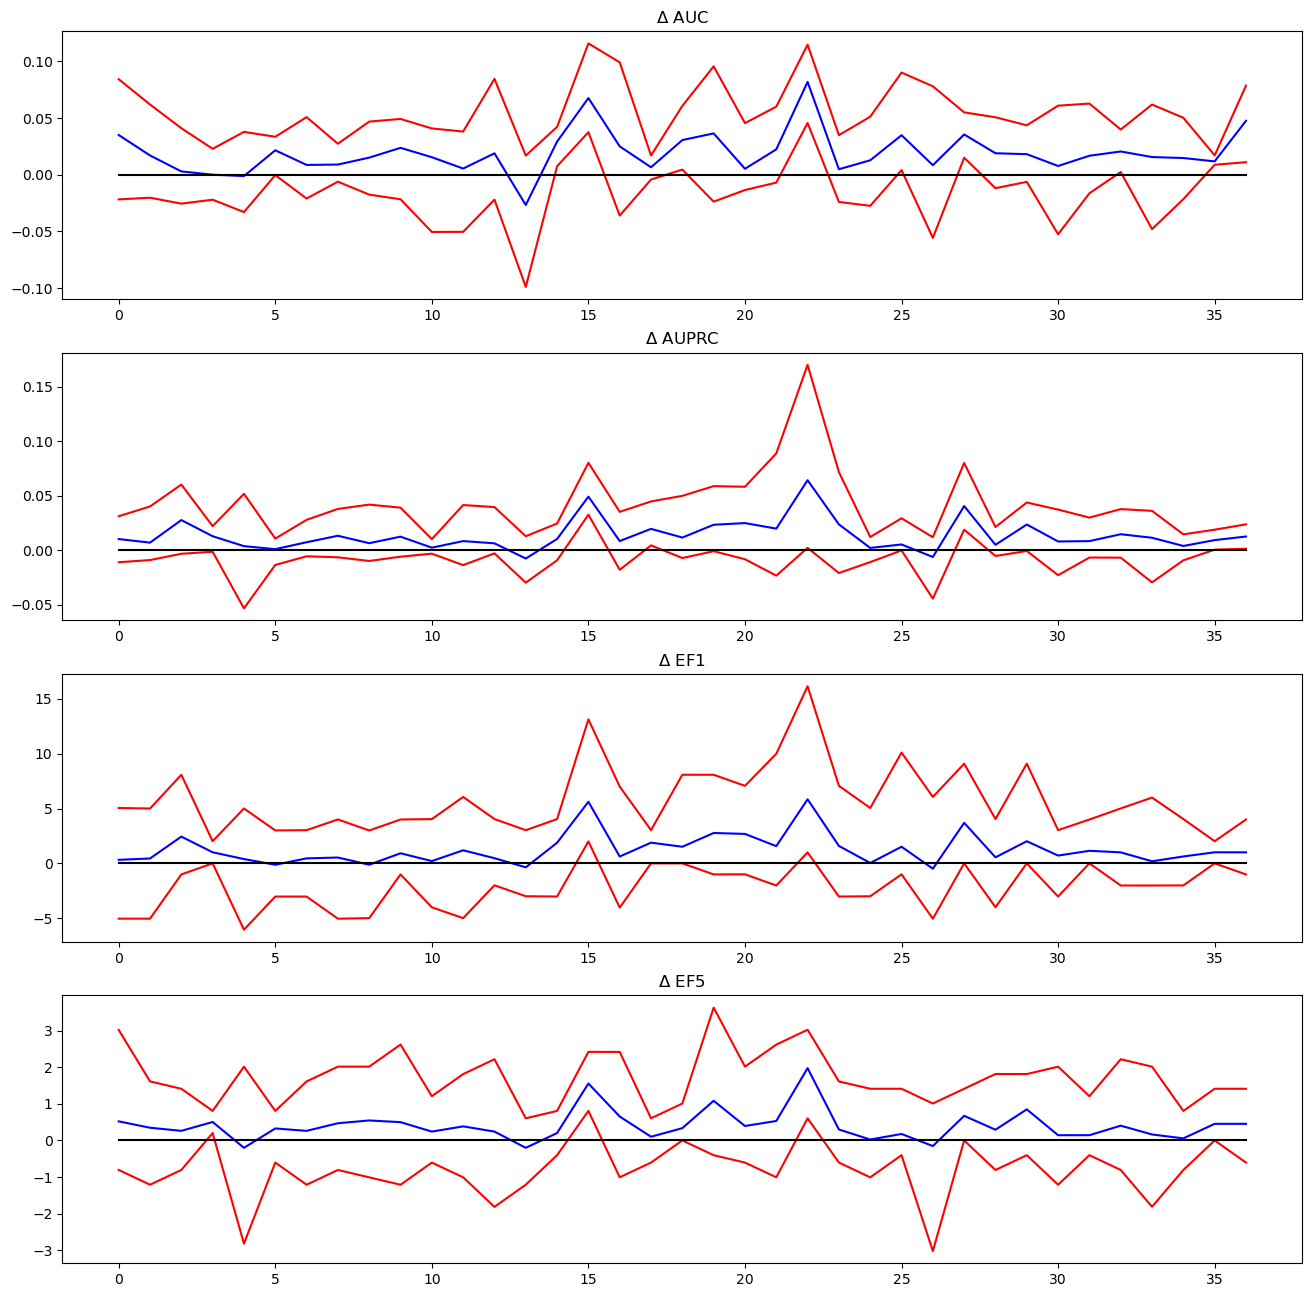

In [47]:
figsize(16,4*len(metrics))
for i,metric in enumerate(metrics):
    subplot(len(metrics),1,i+1)
    plot([x[metric][0] for x in delts.values()],c='b')
    plot([x[metric][1] for x in delts.values()],c='r')
    plot([x[metric][2] for x in delts.values()],c='r')
    plot((0,36),(0,0),'k')
    title(f'$\Delta$ {metric}')



That's a bit clearer in a box plot for the deltas:

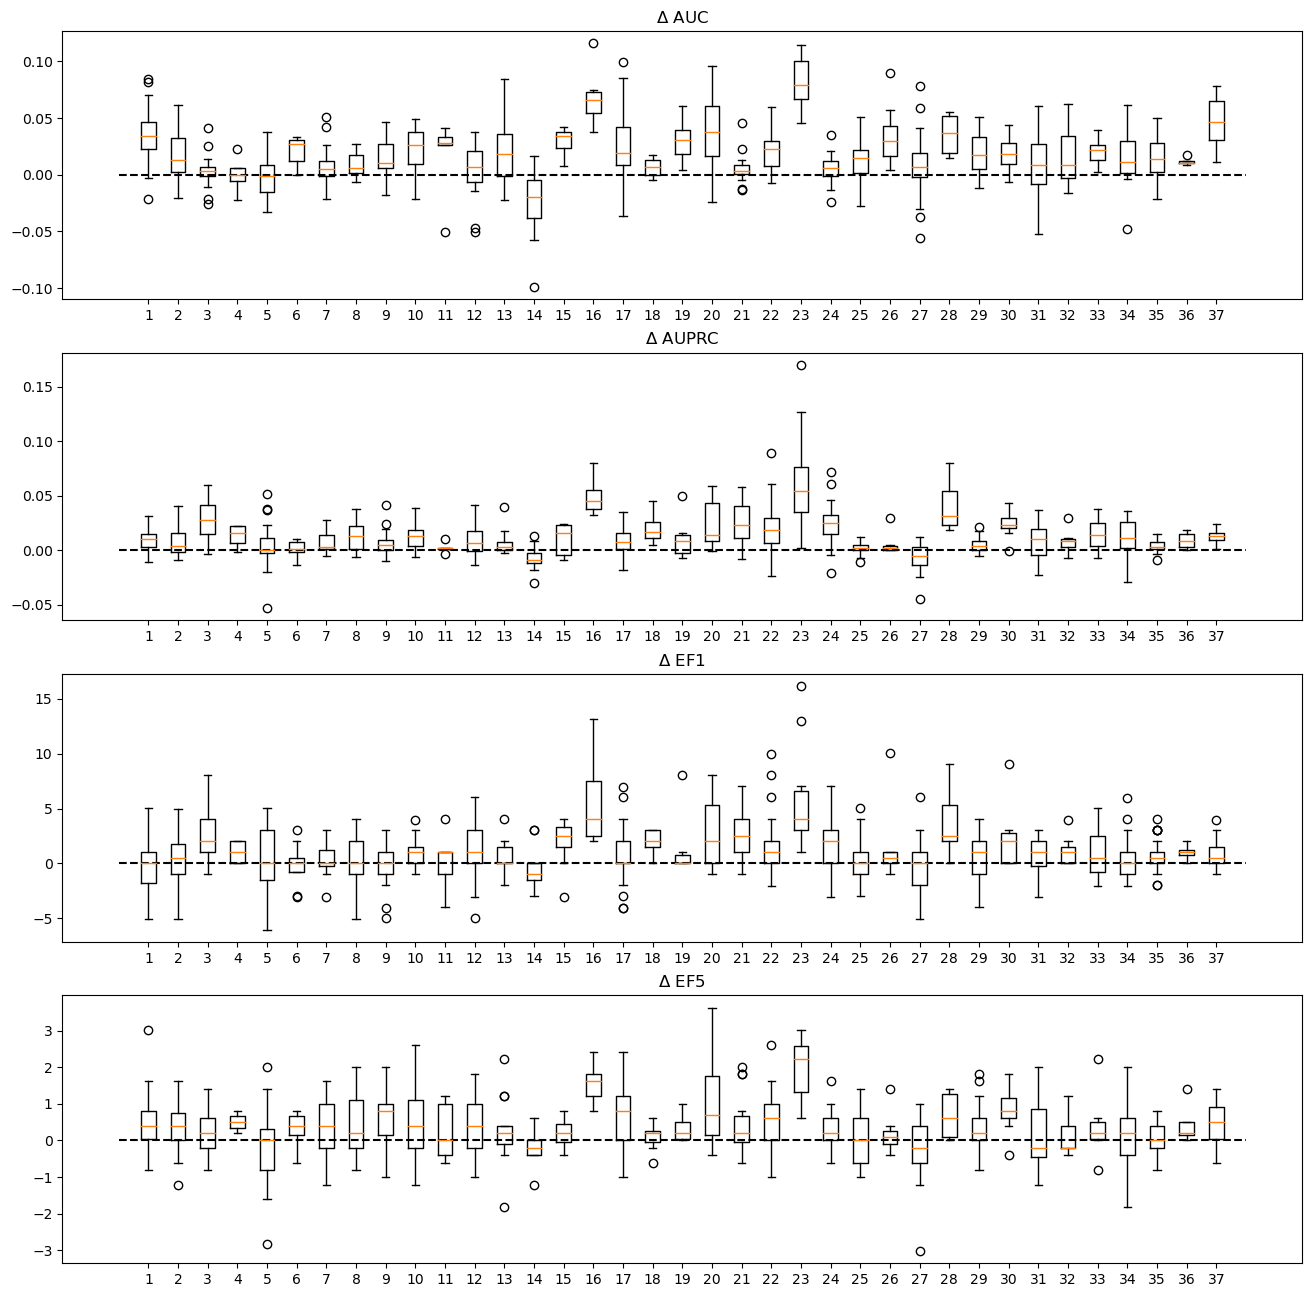

In [48]:
figsize(16,4*len(metrics))
for i,metric in enumerate(metrics):
    subplot(len(metrics),1,i+1)
    _=boxplot([x[metric] for x in fdelts.values()])
    _=plot((0,38),(0,0),c='k',linestyle='--')
    title(f'$\Delta$ {metric}')


# More direct comparisons

Rather than doing a bunch more of the box and whisker plots showing the results broken down by dataset, let's look at direct comparisions of the results for the various learning methods. We can do this because we know what all the method+fp combinations were trained/tested using the same data splits.

In [61]:
def do_scatter_plots(k1,k2,alld=alld,metrics=metrics):
    delts = defaultdict(list)
    v1s = defaultdict(list)
    v2s = defaultdict(list)

    for assay,d in alld.items():
        for metric in metrics:
            v1 = np.array([x[0] for x in d[metric][k1]])
            v2 = np.array([x[0] for x in d[metric][k2]])
            delt=v2-v1
            delts[metric].extend(delt)
            v1s[metric].extend(v1)
            v2s[metric].extend(v2)

    nmetrics = len(metrics)        
    nrows = nmetrics//2 + nmetrics%2
    ncols = 2
    figsize(ncols*4,nrows*4)
    for i,metric in enumerate(metrics):
        subplot(nrows,ncols,i+1)
        scatter(v1s[metric],v2s[metric],marker='.');
        xmin,xmax = xlim()
        ymin,ymax = ylim()
        vmin = min(xmin,ymin)
        vmax = max(xmax,ymax)

        plot((vmin,vmax),(vmin,vmax),'k-');
        xlabel(k1)
        ylabel(k2)
        tight_layout()
        title(metric);    

## Logistic regression

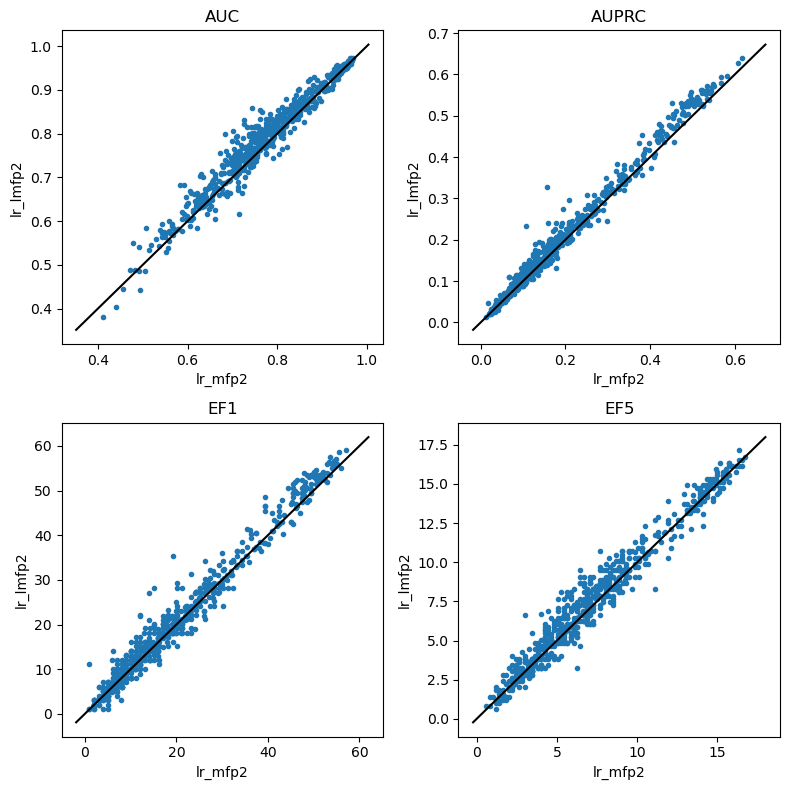

In [63]:
do_scatter_plots('lr_mfp2','lr_lmfp2')

## Balanced random forests

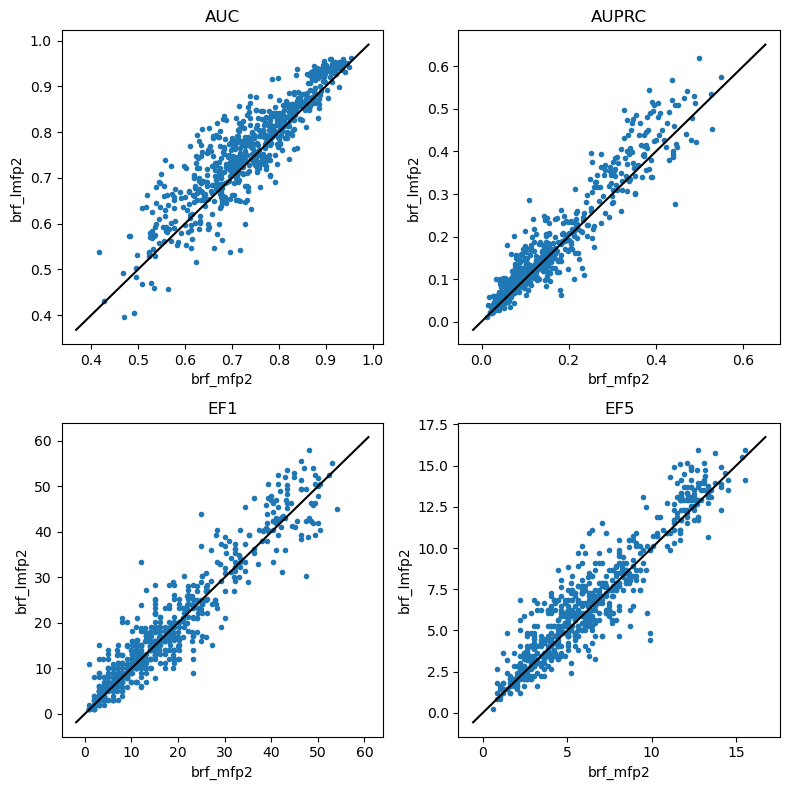

In [64]:
do_scatter_plots('brf_mfp2','brf_lmfp2')

## Random forests

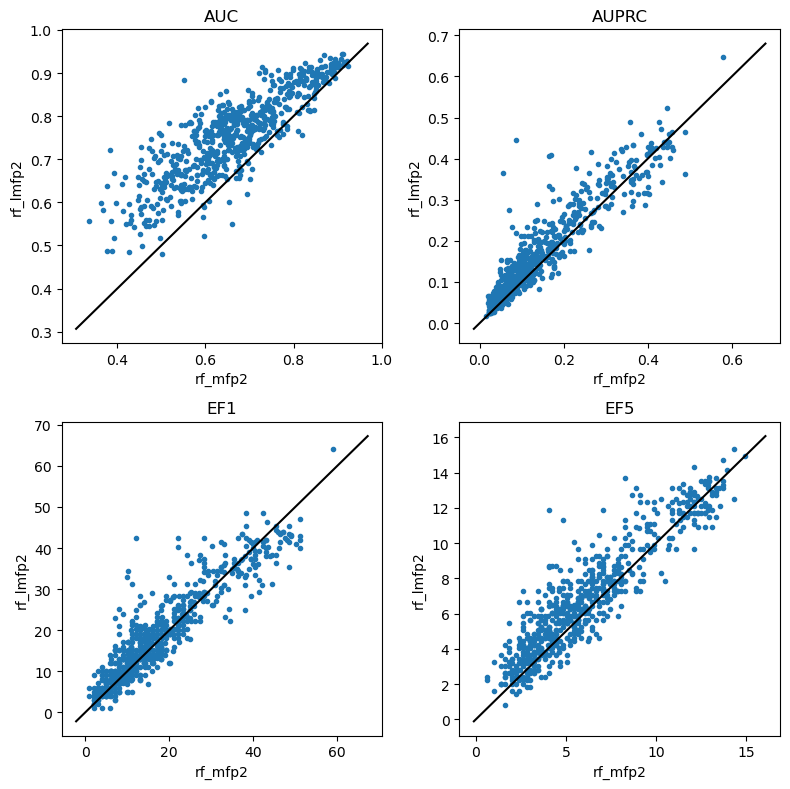

In [65]:
do_scatter_plots('rf_mfp2','rf_lmfp2')

## XGBoost

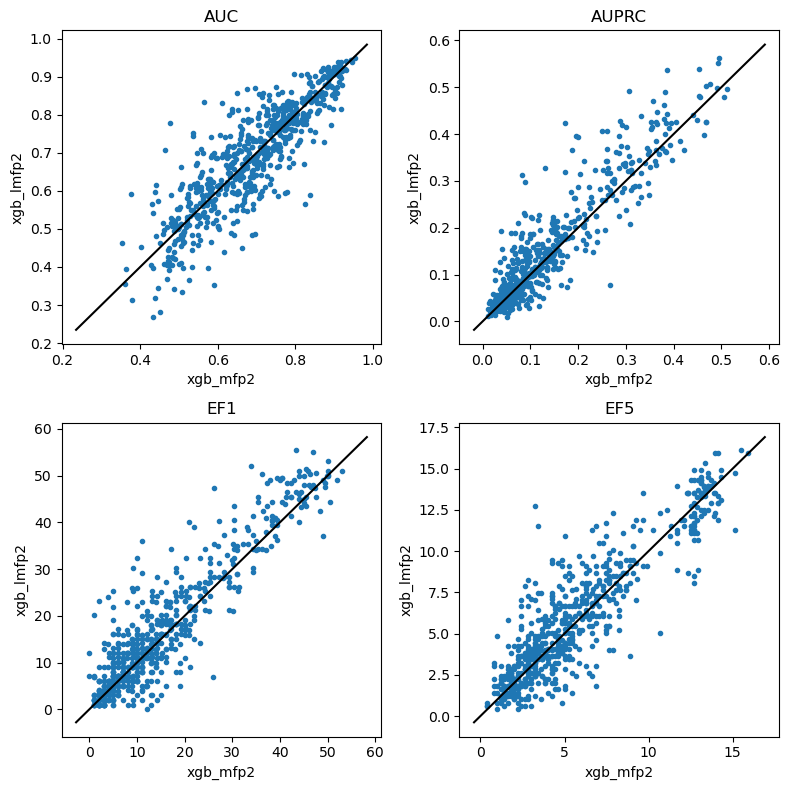

In [68]:
do_scatter_plots('xgb_mfp2','xgb_lmfp2')

## Laplacian Naive Bayes

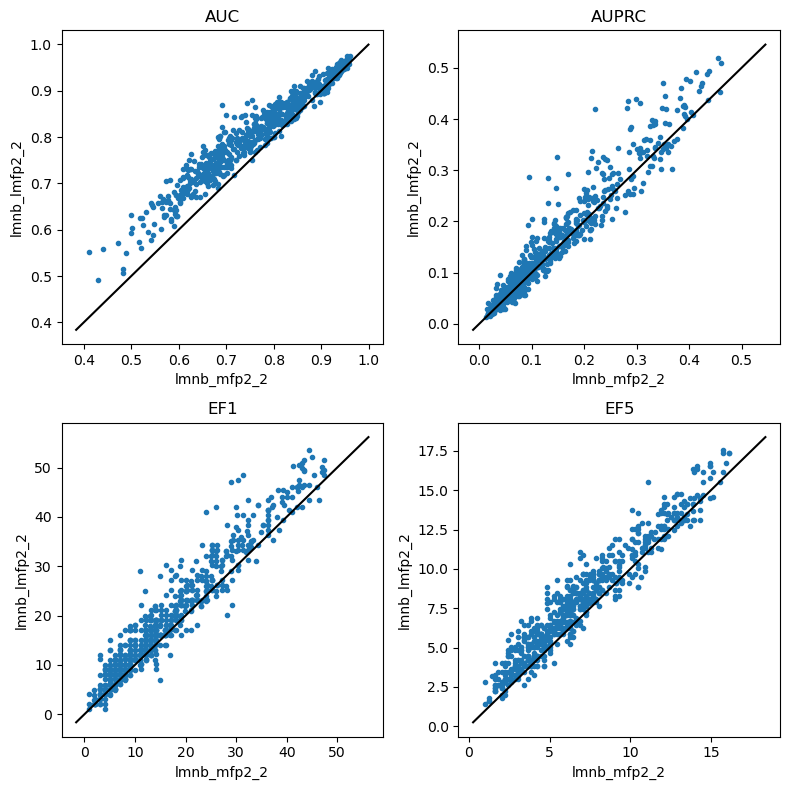

In [67]:
do_scatter_plots('lmnb_mfp2_2','lmnb_lmfp2_2')

## Naive Bayes

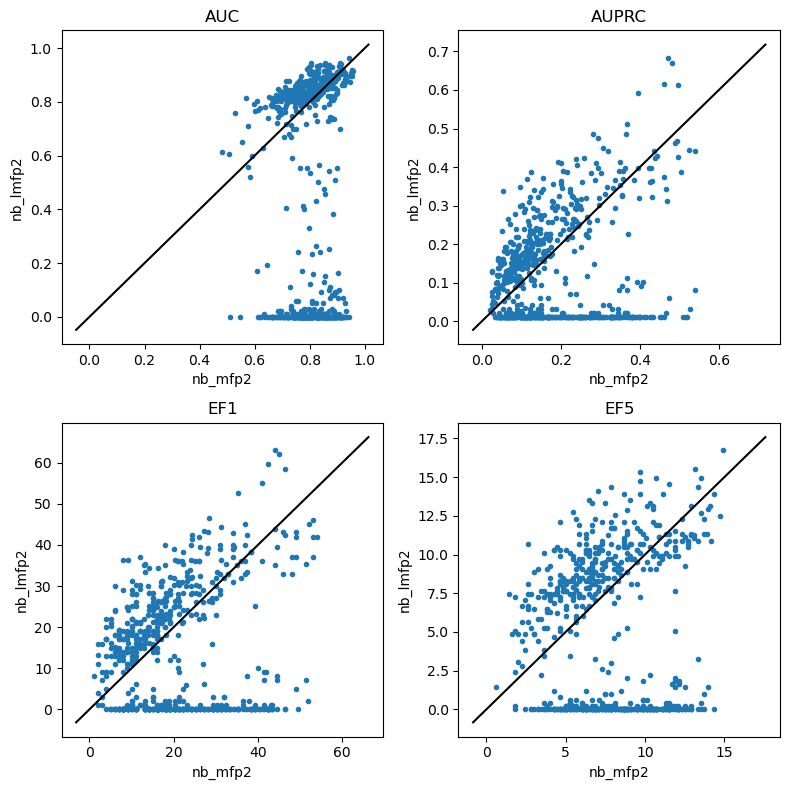

In [66]:
do_scatter_plots('nb_mfp2','nb_lmfp2')

Something isn't right with the NB results... I need to look into that

# Look at morgan 3

This increases the number of set bits

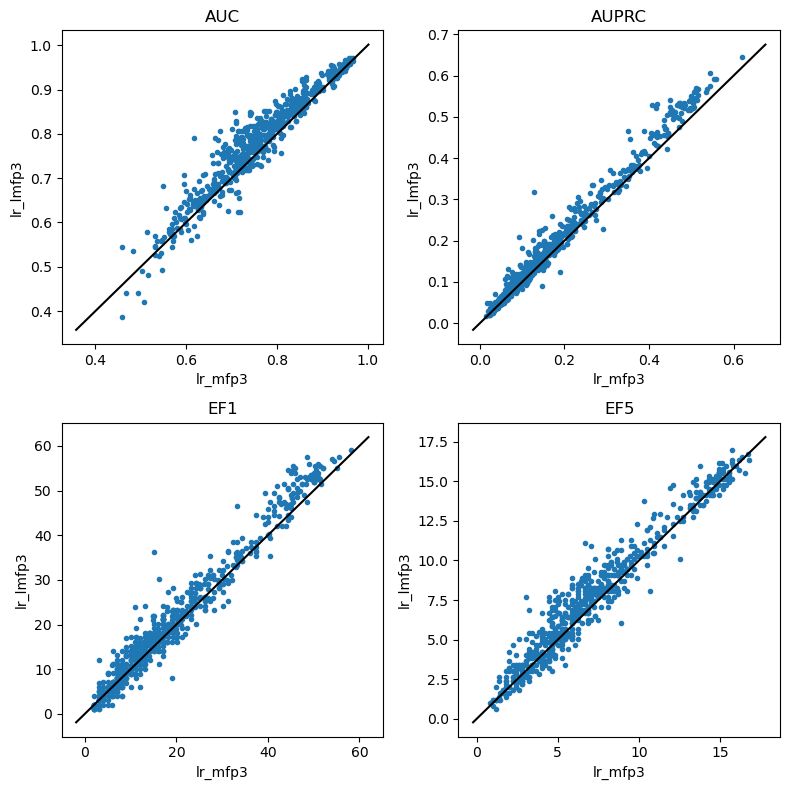

In [70]:
do_scatter_plots('lr_mfp3','lr_lmfp3')

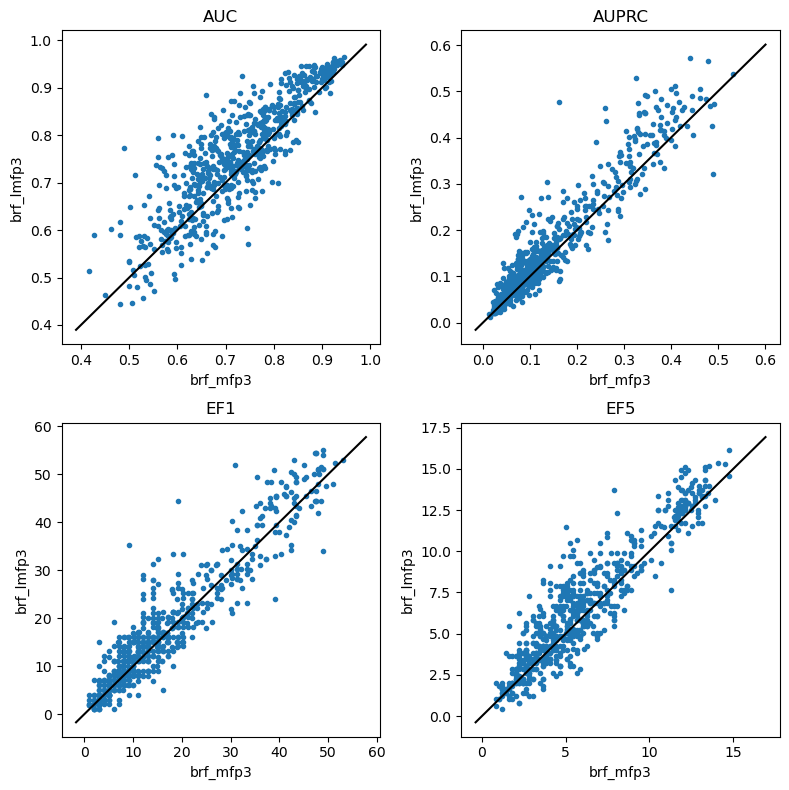

In [71]:
do_scatter_plots('brf_mfp3','brf_lmfp3')

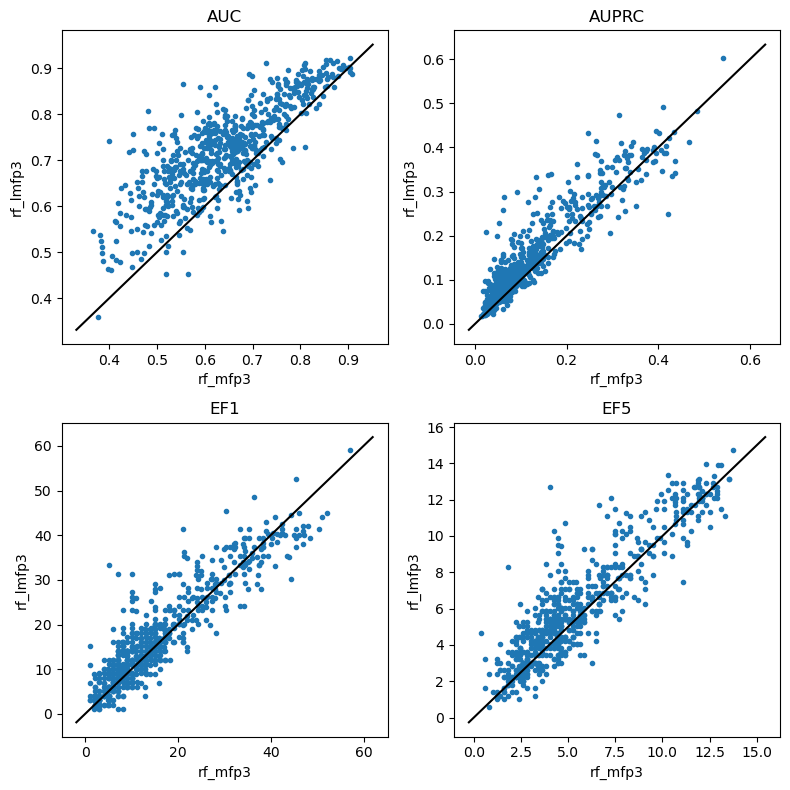

In [72]:
do_scatter_plots('rf_mfp3','rf_lmfp3')

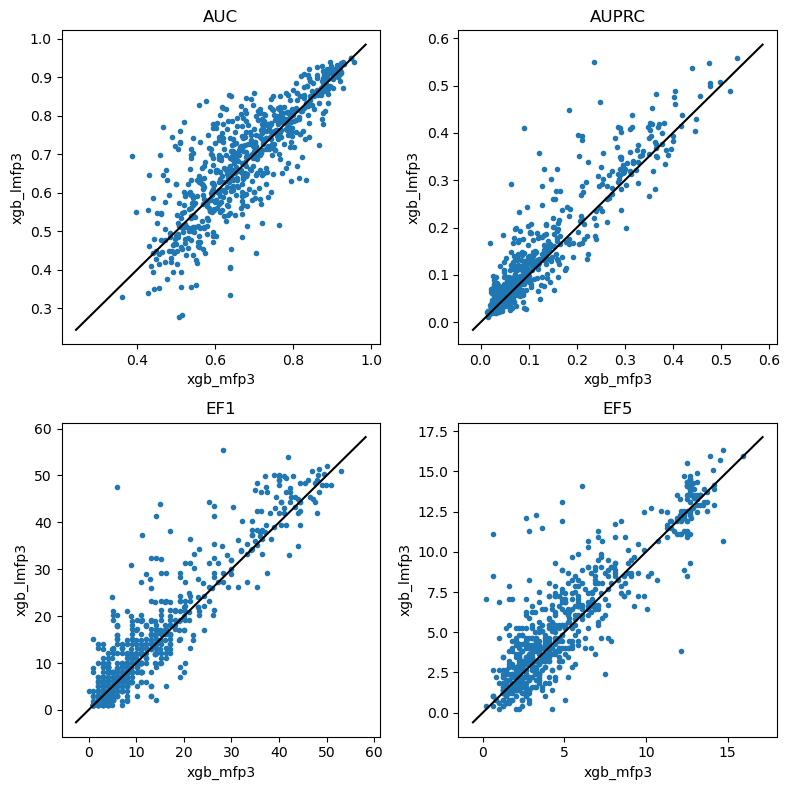

In [73]:
do_scatter_plots('xgb_mfp3','xgb_lmfp3')

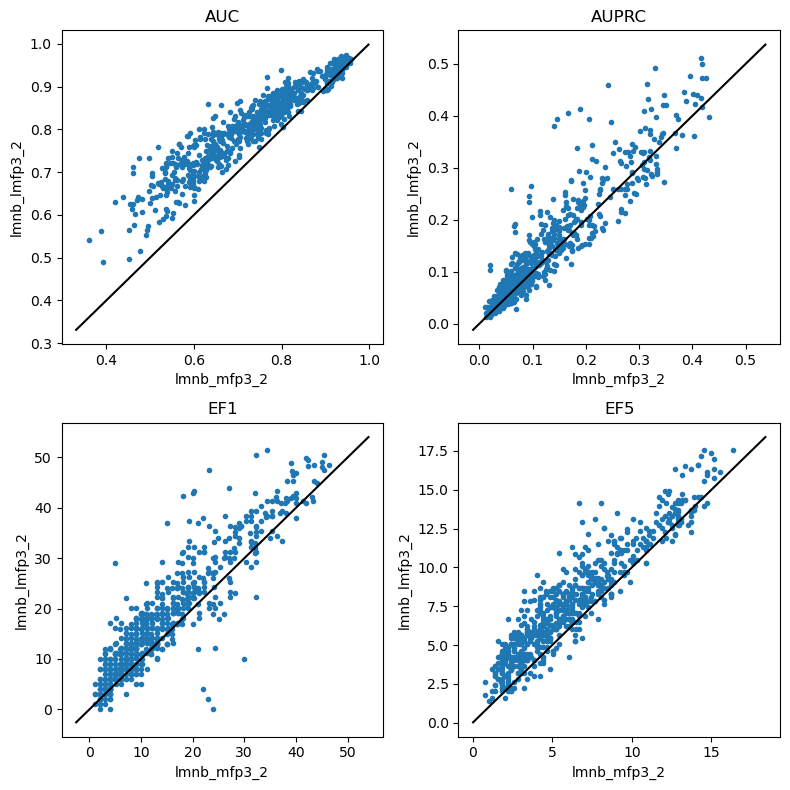

In [75]:
do_scatter_plots('lmnb_mfp3_2','lmnb_lmfp3_2')

# Look at RDK5

Now we really have a lot of set bits

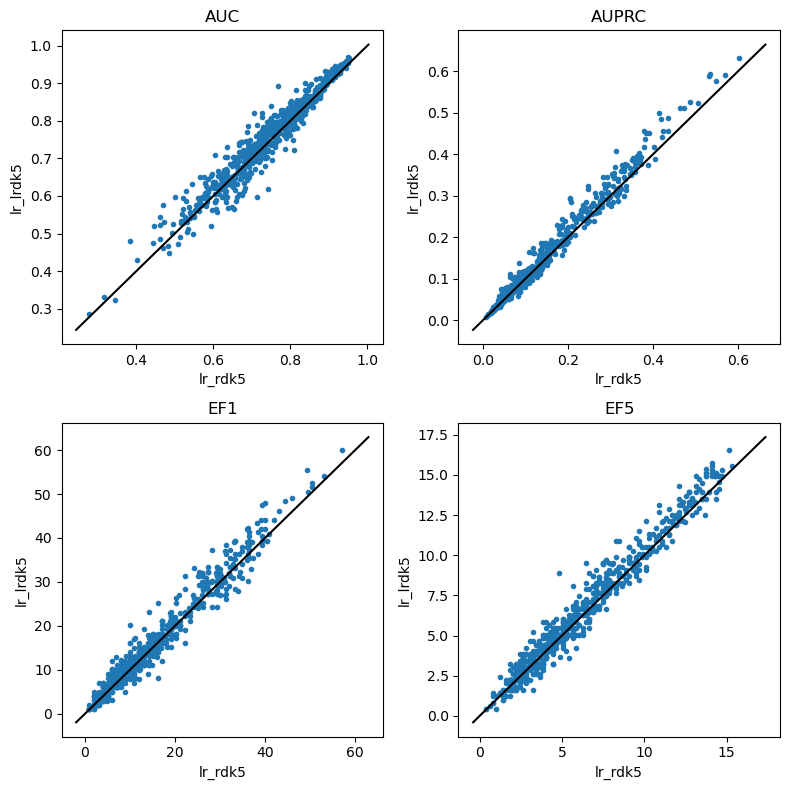

In [77]:
do_scatter_plots('lr_rdk5','lr_lrdk5')

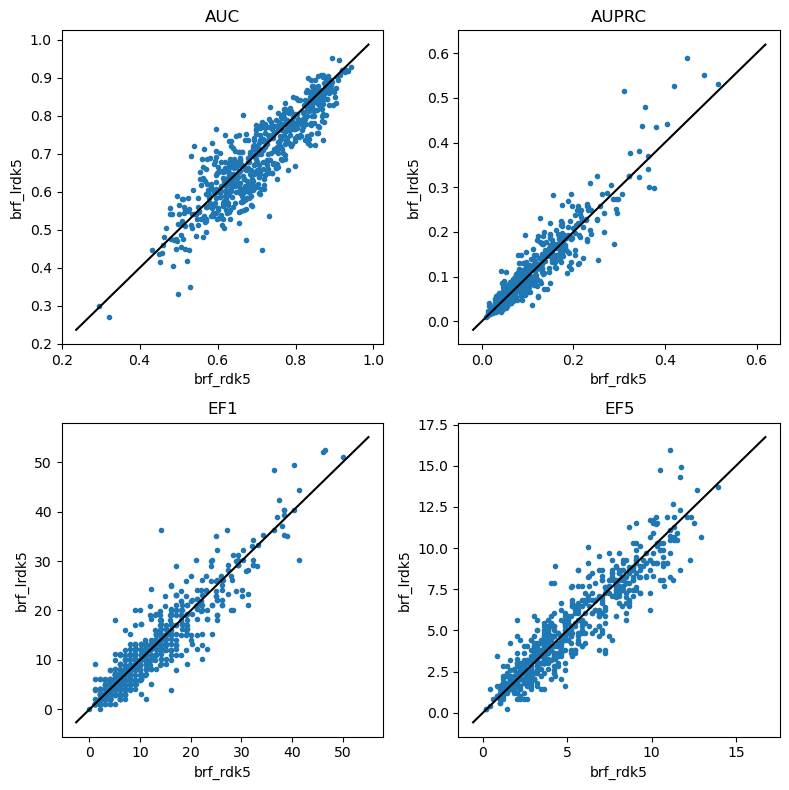

In [78]:
do_scatter_plots('brf_rdk5','brf_lrdk5')

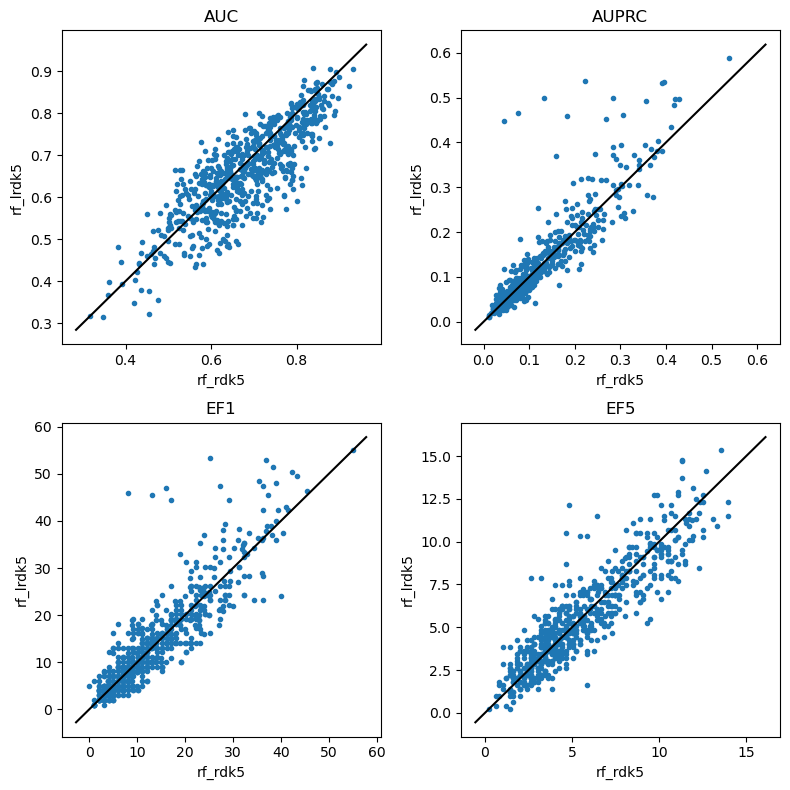

In [80]:
do_scatter_plots('rf_rdk5','rf_lrdk5')

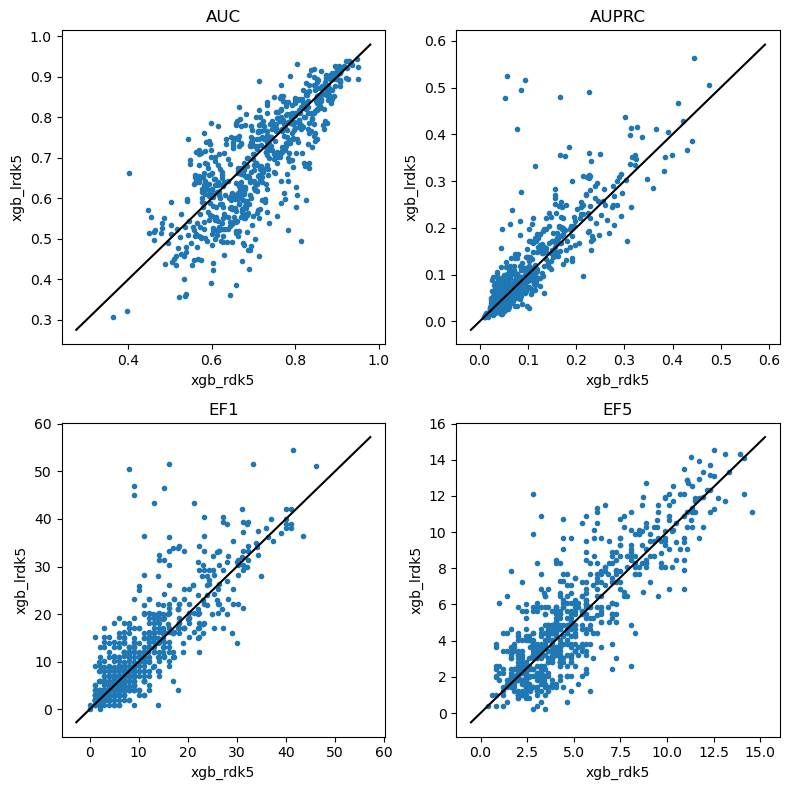

In [81]:
do_scatter_plots('xgb_rdk5','xgb_lrdk5')

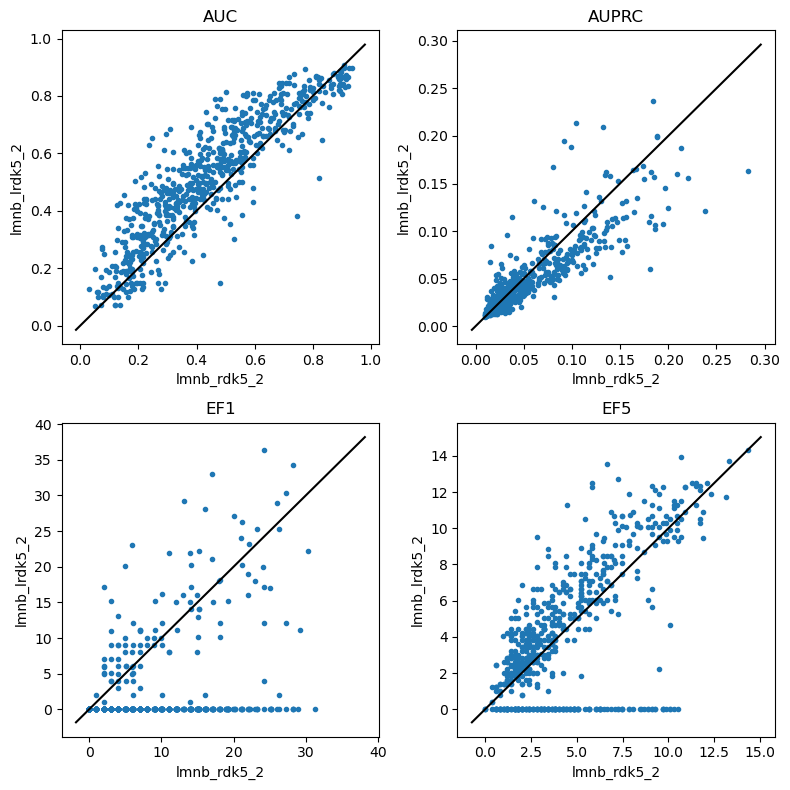

In [82]:
do_scatter_plots('lmnb_rdk5_2','lmnb_lrdk5_2')

Again, some of those enrichment plots look suspicious and should be looked into

# Are there statistically significant differences?

Use the Wilcoxon signed-rank test to detect whether or not the differences we saw in the plots are statistically significant. We'll do this for every method and fingerprint and make a table.

In [84]:
from scipy import stats

In [128]:
def do_significance(alg,fp,tableOutput=False,showHeader=False,pthresh=0.001,alld=alld,metrics=metrics):
    k1 = f'{alg}_{fp}'
    k2 = f'{alg}_l{fp}'
    if alg == 'lmnb':
        k1 += '_2'
        k2 += '_2'

    
    v1s = defaultdict(list)
    v2s = defaultdict(list)
    delts = defaultdict(list)
    pct_delts = defaultdict(list)

    if tableOutput and showHeader:
        row = ('alg','fp','metric','result','P','delt','pct_delt')
        divider = ['-'*len(k) for k in row]
        print('| '+' | '.join(row)+' |')
        print('| '+' | '.join(divider)+' |')
        
        
    for assay,d in alld.items():
        for metric in metrics:
            v1 = np.array([x[0] for x in d[metric][k1]])
            v2 = np.array([x[0] for x in d[metric][k2]])
            v1s[metric].extend(v1)
            v2s[metric].extend(v2)
            delt = v1-v2
            delts[metric].extend(delt)
            pct_delts[metric].extend(delt/v1)
    for metric in metrics:
        w2s = stats.wilcoxon(v1s[metric],v2s[metric],alternative='two-sided').pvalue
        wlt = stats.wilcoxon(v1s[metric],v2s[metric],alternative='less').pvalue
        wgt = stats.wilcoxon(v1s[metric],v2s[metric],alternative='greater').pvalue
        result = 'same'
        which = w2s
        if w2s < pthresh:
            if wlt < pthresh:
                result = 'lt'
                which = wlt
            elif wgt < pthresh:
                result = 'gt'
                which = wgt
        row = (alg,fp,metric,result,f'{which:.3g}',f'{np.median(delts[metric]):.2g}',f'{np.median(pct_delts[metric]):.3g}')
        if not tableOutput:
            print(' '.join(row))
        else:
            print('| '+' | '.join(row)+' |')

# we skip 'nb' here since there's clearly something bogus with the results
for metric in metrics:
    print(f'## {metric}')
    for i,alg in enumerate(('lr','lmnb','rf','brf','xgb')):
        for j,fp in enumerate(('mfp2','mfp3','rdk5','hashap','hashtt')):
            do_significance(alg,fp,tableOutput=True,showHeader=(not i + j),metrics=(metric,))
    print('\n\n')


## AUC
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | AUC | lt | 8.68e-51 | -0.011 | -0.0142 |
| lr | mfp3 | AUC | lt | 2.6e-64 | -0.019 | -0.0243 |
| lr | rdk5 | AUC | lt | 2.09e-24 | -0.011 | -0.0143 |
| lr | hashap | AUC | lt | 8.77e-37 | -0.026 | -0.0325 |
| lr | hashtt | AUC | lt | 8.02e-54 | -0.022 | -0.0294 |
| lmnb | mfp2 | AUC | lt | 3.2e-104 | -0.042 | -0.0573 |
| lmnb | mfp3 | AUC | lt | 6.05e-107 | -0.077 | -0.109 |
| lmnb | rdk5 | AUC | lt | 4.32e-60 | -0.071 | -0.193 |
| lmnb | hashap | AUC | gt | 1.67e-18 | 0.031 | 0.0494 |
| lmnb | hashtt | AUC | lt | 7.52e-105 | -0.051 | -0.0767 |
| rf | mfp2 | AUC | lt | 1.45e-102 | -0.087 | -0.132 |
| rf | mfp3 | AUC | lt | 2.23e-92 | -0.074 | -0.115 |
| rf | rdk5 | AUC | gt | 4.27e-11 | 0.015 | 0.0212 |
| rf | hashap | AUC | same | 0.00227 | 0.0036 | 0.00503 |
| rf | hashtt | AUC | lt | 1.25e-63 | -0.046 | -0.0677 |
| brf | mfp2 | AUC | lt | 6.61e-37 | -0.024 |

C:\Users\glandrum\AppData\Local\Temp\ipykernel_9592\1757963699.py:29: RuntimeWarning: invalid value encountered in divide
  pct_delts[metric].extend(delt/v1)
C:\Users\glandrum\AppData\Local\Temp\ipykernel_9592\1757963699.py:29: RuntimeWarning: divide by zero encountered in divide
  pct_delts[metric].extend(delt/v1)


| lr | hashap | EF5 | lt | 1.42e-08 | -0.2 | -0.0385 |
| lr | hashtt | EF5 | lt | 6.58e-38 | -0.4 | -0.0769 |
| lmnb | mfp2 | EF5 | lt | 1.44e-82 | -1 | -0.154 |
| lmnb | mfp3 | EF5 | lt | 2.57e-92 | -1.4 | -0.264 |
| lmnb | rdk5 | EF5 | same | 0.725 | -0.4 | nan |
| lmnb | hashap | EF5 | lt | 1.47e-64 | -1 | -0.217 |
| lmnb | hashtt | EF5 | lt | 6.85e-73 | -0.81 | -0.185 |
| rf | mfp2 | EF5 | lt | 3.72e-39 | -0.61 | -0.118 |
| rf | mfp3 | EF5 | lt | 3.14e-26 | -0.4 | -0.0948 |
| rf | rdk5 | EF5 | same | 0.988 | 0 | 0 |
| rf | hashap | EF5 | gt | 6.9e-14 | 0.61 | 0.0769 |
| rf | hashtt | EF5 | lt | 2.61e-19 | -0.4 | -0.0811 |
| brf | mfp2 | EF5 | lt | 4.02e-16 | -0.4 | -0.0476 |
| brf | mfp3 | EF5 | lt | 8.91e-25 | -0.6 | -0.0854 |
| brf | rdk5 | EF5 | same | 0.319 | 0 | 0 |
| brf | hashap | EF5 | gt | 9.01e-07 | 0.4 | 0.0674 |
| brf | hashtt | EF5 | lt | 1.18e-22 | -0.4 | -0.101 |
| xgb | mfp2 | EF5 | lt | 3.14e-05 | -0.2 | -0.0308 |
| xgb | mfp3 | EF5 | lt | 4.57e-13 | -0.4 | -0.0797

And now display that:

## AUC
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | AUC | lt | 8.68e-51 | -0.011 | -0.0142 |
| lr | mfp3 | AUC | lt | 2.6e-64 | -0.019 | -0.0243 |
| lr | rdk5 | AUC | lt | 2.09e-24 | -0.011 | -0.0143 |
| lr | hashap | AUC | lt | 8.77e-37 | -0.026 | -0.0325 |
| lr | hashtt | AUC | lt | 8.02e-54 | -0.022 | -0.0294 |
| lmnb | mfp2 | AUC | lt | 3.2e-104 | -0.042 | -0.0573 |
| lmnb | mfp3 | AUC | lt | 6.05e-107 | -0.077 | -0.109 |
| lmnb | rdk5 | AUC | lt | 4.32e-60 | -0.071 | -0.193 |
| lmnb | hashap | AUC | gt | 1.67e-18 | 0.031 | 0.0494 |
| lmnb | hashtt | AUC | lt | 7.52e-105 | -0.051 | -0.0767 |
| rf | mfp2 | AUC | lt | 1.45e-102 | -0.087 | -0.132 |
| rf | mfp3 | AUC | lt | 2.23e-92 | -0.074 | -0.115 |
| rf | rdk5 | AUC | gt | 4.27e-11 | 0.015 | 0.0212 |
| rf | hashap | AUC | same | 0.00227 | 0.0036 | 0.00503 |
| rf | hashtt | AUC | lt | 1.25e-63 | -0.046 | -0.0677 |
| brf | mfp2 | AUC | lt | 6.61e-37 | -0.024 | -0.0304 |
| brf | mfp3 | AUC | lt | 9.25e-40 | -0.031 | -0.04 |
| brf | rdk5 | AUC | gt | 2.77e-09 | 0.01 | 0.0131 |
| brf | hashap | AUC | gt | 5.32e-07 | 0.011 | 0.0152 |
| brf | hashtt | AUC | lt | 8.45e-29 | -0.027 | -0.0362 |
| xgb | mfp2 | AUC | same | 0.831 | 0.00097 | 0.00109 |
| xgb | mfp3 | AUC | same | 0.00162 | -0.0051 | -0.00719 |
| xgb | rdk5 | AUC | gt | 1.36e-07 | 0.012 | 0.0157 |
| xgb | hashap | AUC | gt | 1.49e-20 | 0.027 | 0.0358 |
| xgb | hashtt | AUC | same | 0.0265 | -0.0043 | -0.00645 |



## AUPRC
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | AUPRC | lt | 9.58e-55 | -0.0079 | -0.0535 |
| lr | mfp3 | AUPRC | lt | 1.72e-71 | -0.011 | -0.0758 |
| lr | rdk5 | AUPRC | lt | 2.93e-38 | -0.0042 | -0.0508 |
| lr | hashap | AUPRC | lt | 1.11e-13 | -0.01 | -0.0857 |
| lr | hashtt | AUPRC | lt | 2.33e-60 | -0.0091 | -0.102 |
| lmnb | mfp2 | AUPRC | lt | 9.34e-31 | -0.009 | -0.101 |
| lmnb | mfp3 | AUPRC | lt | 5.43e-27 | -0.0099 | -0.135 |
| lmnb | rdk5 | AUPRC | gt | 0.000113 | 0.00025 | 0.00953 |
| lmnb | hashap | AUPRC | lt | 1.02e-18 | -0.0052 | -0.114 |
| lmnb | hashtt | AUPRC | lt | 2.39e-17 | -0.0039 | -0.0839 |
| rf | mfp2 | AUPRC | lt | 3.24e-46 | -0.017 | -0.174 |
| rf | mfp3 | AUPRC | lt | 3.09e-59 | -0.019 | -0.211 |
| rf | rdk5 | AUPRC | same | 0.41 | 1.1e-05 | 0.000428 |
| rf | hashap | AUPRC | gt | 2.54e-05 | 0.011 | 0.1 |
| rf | hashtt | AUPRC | lt | 8.39e-42 | -0.011 | -0.14 |
| brf | mfp2 | AUPRC | lt | 1.41e-22 | -0.0086 | -0.0915 |
| brf | mfp3 | AUPRC | lt | 4.72e-35 | -0.012 | -0.119 |
| brf | rdk5 | AUPRC | same | 0.455 | -0.00027 | -0.00484 |
| brf | hashap | AUPRC | gt | 0.00023 | 0.0058 | 0.0642 |
| brf | hashtt | AUPRC | lt | 3.38e-26 | -0.0075 | -0.121 |
| xgb | mfp2 | AUPRC | lt | 1.34e-12 | -0.0044 | -0.0558 |
| xgb | mfp3 | AUPRC | lt | 1.74e-25 | -0.0088 | -0.113 |
| xgb | rdk5 | AUPRC | lt | 1.32e-08 | -0.0034 | -0.0545 |
| xgb | hashap | AUPRC | same | 0.221 | 0.008 | 0.0872 |
| xgb | hashtt | AUPRC | lt | 1.07e-13 | -0.0044 | -0.0792 |



## EF1
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | EF1 | lt | 4.4e-23 | -1 | -0.0357 |
| lr | mfp3 | EF1 | lt | 1.24e-36 | -1 | -0.0625 |
| lr | rdk5 | EF1 | lt | 7.74e-16 | 0 | 0 |
| lr | hashap | EF1 | lt | 3.05e-06 | -1 | -0.0556 |
| lr | hashtt | EF1 | lt | 5.74e-36 | -1 | -0.0833 |
| lmnb | mfp2 | EF1 | lt | 2.32e-74 | -3 | -0.167 |
| lmnb | mfp3 | EF1 | lt | 9.4e-69 | -3 | -0.25 |
| lmnb | rdk5 | EF1 | gt | 1.97e-58 | 4 | nan |
| lmnb | hashap | EF1 | same | 0.147 | -1 | nan |
| lmnb | hashtt | EF1 | lt | 5.42e-48 | -2 | -0.2 |
| rf | mfp2 | EF1 | lt | 4.12e-11 | -1 | -0.0706 |
| rf | mfp3 | EF1 | lt | 1.94e-14 | -1 | -0.0833 |
| rf | rdk5 | EF1 | same | 0.0619 | 0 | 0 |
| rf | hashap | EF1 | gt | 3.15e-06 | 2 | 0.1 |
| rf | hashtt | EF1 | lt | 1.33e-09 | -1 | -0.0476 |
| brf | mfp2 | EF1 | lt | 2.84e-09 | -1 | -0.0421 |
| brf | mfp3 | EF1 | lt | 4.46e-13 | -1 | -0.0769 |
| brf | rdk5 | EF1 | same | 0.301 | 0 | nan |
| brf | hashap | EF1 | gt | 9.93e-09 | 1 | 0.0779 |
| brf | hashtt | EF1 | lt | 7.97e-14 | -1 | -0.0871 |
| xgb | mfp2 | EF1 | lt | 1.06e-14 | -1 | -0.075 |
| xgb | mfp3 | EF1 | lt | 2.22e-17 | -1 | -0.0625 |
| xgb | rdk5 | EF1 | lt | 4.54e-09 | -1 | nan |
| xgb | hashap | EF1 | same | 0.335 | 1 | 0.0769 |
| xgb | hashtt | EF1 | lt | 6.27e-09 | 0 | 0 |



## EF5
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lr | mfp2 | EF5 | lt | 4.32e-23 | -0.2 | -0.0357 |
| lr | mfp3 | EF5 | lt | 3.64e-38 | -0.4 | -0.0559 |
| lr | rdk5 | EF5 | lt | 8.96e-26 | -0.2 | -0.0469 |
| lr | hashap | EF5 | lt | 1.42e-08 | -0.2 | -0.0385 |
| lr | hashtt | EF5 | lt | 6.58e-38 | -0.4 | -0.0769 |
| lmnb | mfp2 | EF5 | lt | 1.44e-82 | -1 | -0.154 |
| lmnb | mfp3 | EF5 | lt | 2.57e-92 | -1.4 | -0.264 |
| lmnb | rdk5 | EF5 | same | 0.725 | -0.4 | nan |
| lmnb | hashap | EF5 | lt | 1.47e-64 | -1 | -0.217 |
| lmnb | hashtt | EF5 | lt | 6.85e-73 | -0.81 | -0.185 |
| rf | mfp2 | EF5 | lt | 3.72e-39 | -0.61 | -0.118 |
| rf | mfp3 | EF5 | lt | 3.14e-26 | -0.4 | -0.0948 |
| rf | rdk5 | EF5 | same | 0.988 | 0 | 0 |
| rf | hashap | EF5 | gt | 6.9e-14 | 0.61 | 0.0769 |
| rf | hashtt | EF5 | lt | 2.61e-19 | -0.4 | -0.0811 |
| brf | mfp2 | EF5 | lt | 4.02e-16 | -0.4 | -0.0476 |
| brf | mfp3 | EF5 | lt | 8.91e-25 | -0.6 | -0.0854 |
| brf | rdk5 | EF5 | same | 0.319 | 0 | 0 |
| brf | hashap | EF5 | gt | 9.01e-07 | 0.4 | 0.0674 |
| brf | hashtt | EF5 | lt | 1.18e-22 | -0.4 | -0.101 |
| xgb | mfp2 | EF5 | lt | 3.14e-05 | -0.2 | -0.0308 |
| xgb | mfp3 | EF5 | lt | 4.57e-13 | -0.4 | -0.0797 |
| xgb | rdk5 | EF5 | same | 0.00432 | -0.2 | -0.0354 |
| xgb | hashap | EF5 | gt | 1.24e-09 | 0.61 | 0.1 |

I am sorely tempted to compare the individual methods and fingerprints to each other as well, but that's not the point of this post, so I'll hold that for another time.